# Mini-Project 1

In [1]:
# Load the library and the data. Please setup the symbols in the config.toml file, and run data_update.py to get the data file.
import pandas as pd
import numpy as np
from scipy.optimize import minimize
from src.utils import parse_config, get_logger, load_market_data
from src import Agent, Backtester

config = parse_config()
logger = get_logger("backtest", config)
market_data = load_market_data(config)
backtester = Backtester(market_data, config, logger)

market_data.head(10)

open        high         low       close     volume
date       symbol                                                           
2020-01-02 AAPL     71.627107   72.681304   71.373233   72.620857  135480400
           CVX      94.516478   95.158010   94.485183   95.001541    5205000
           F         7.105235    7.204662    7.028752    7.204662   43425700
           GLD     143.860001  144.210007  143.399994  143.949997    7733800
           HD      191.795242  192.390547  190.709670  192.303009    3935700
           JNJ     124.898045  125.026487  124.221630  124.983673    5777000
           JPM     119.621120  120.742124  119.167589  120.733559   10803700
           LMT     338.845053  344.459991  337.197685  344.459991    1258400
           MSFT    151.289123  153.147124  150.860356  153.042313   22622100
           NKE      94.584357   95.377536   94.267082   95.368202    5644100

In [2]:
class SimpleBuyAndHoldAgent(Agent):
    def __init__(self, weights: dict):
        """
        weights: dict of {symbol: weight}, must sum to 1.0
        """
        self.weights = weights
        self.acted = False  # whether initial orders have been placed
    def act(self, date: pd.Timestamp, market_data: pd.DataFrame, portfolio: dict, cash: float):
        if self.acted:
            return []  # do nothing

        orders = []
        for symbol, weight in self.weights.items():
            if symbol not in market_data.index:
                continue
            close_price = market_data.loc[symbol, "close"]
            allocation = cash * weight
            quantity = int(allocation // close_price)
            if quantity > 0:
                orders.append((symbol, close_price, quantity))

        self.acted = True
        return orders

## Theoretical Result from the Markowitz portfolio theory (Long only)

In [31]:
def compute_asset_stats(df: pd.DataFrame):
    # Unstack to get a wide format: rows = dates, columns = symbols
    prices = df['close'].unstack(level='symbol').sort_index()

    returns = (prices / prices.shift(1)).dropna()-1

    # Annualized mean and volatility
    mean_log_returns = returns.mean()
    std_log_returns = returns.std()

    annual_return = mean_log_returns * 252
    annual_volatility = std_log_returns * np.sqrt(252)

    stats_df = pd.DataFrame({
        'annual_log_return': annual_return,
        'volatility': annual_volatility
    })

    return stats_df

def compute_covariance_matrix(df: pd.DataFrame):
    prices = df['close'].unstack(level='symbol').sort_index()
    log_returns = np.log(prices / prices.shift(1)).dropna()
    return log_returns.cov() * 252  # annualized

def optimize_portfolio(mu, cov, risk_free_rate=0.0, objective='sharpe'):
    symbols = mu.index.tolist()
    n = len(symbols)

    def portfolio_stats(weights):
        w = np.array(weights)
        ret = np.dot(w, mu)
        vol = np.sqrt(np.dot(w, np.dot(cov, w)))
        sharpe = (ret - risk_free_rate) / vol if vol > 0 else -np.inf
        return ret, vol, sharpe

    def objective_fn(weights):
        ret, vol, sharpe = portfolio_stats(weights)
        if objective == 'sharpe':
            return -sharpe
        elif objective == 'min_vol':
            return vol
        else:
            raise ValueError("Unknown objective")

    # Constraints: weights sum to 1
    constraints = [{'type': 'eq', 'fun': lambda w: np.sum(w) - 1}]
    bounds = [(0, 1) for _ in range(n)]  # long-only

    # Initial guess: equal weight
    x0 = np.ones(n) / n

    result = minimize(objective_fn, x0, method='SLSQP', bounds=bounds, constraints=constraints)
    opt_weights = pd.Series(result.x, index=symbols)

    ret, vol, sharpe = portfolio_stats(result.x)
    return {
        'weights': opt_weights,
        'expected_return': ret,
        'volatility': vol,
        'sharpe': sharpe
    }

In [32]:
stats = compute_asset_stats(market_data)
cov = compute_covariance_matrix(market_data)

mu = stats['annual_log_return']
risk_free_rate = config['Backtest']['interest_rate']

# High-risk (max Sharpe)
high_risk_portfolio = optimize_portfolio(mu, cov, risk_free_rate, objective='sharpe')
high_risk_weight_dict = high_risk_portfolio['weights'].sort_values(ascending=False).to_dict()

# Low-risk (min volatility)
low_risk_portfolio = optimize_portfolio(mu, cov, risk_free_rate, objective='min_vol')
low_risk_weight_dict = low_risk_portfolio['weights'].sort_values(ascending=False).to_dict()


print("High Risk Portfolio (Max Sharpe):")
print("Weights: ", end = '{ ')
for key, value in high_risk_weight_dict.items():
    if value > 0.0001:
        print(f"{key}: {value:.4f}", end=', ')
print("}")
print(f"Expected Return: {high_risk_portfolio['expected_return']:.4f}")
print(f"Volatility: {high_risk_portfolio['volatility']:.4f}")
print(f"Sharpe: {high_risk_portfolio['sharpe']:.4f}")

print("\nLow Risk Portfolio (Min Volatility):")
print("Weights: ", end = '{ ')
for key, value in low_risk_weight_dict.items():
    if value > 0.0001:
        print(f"{key}: {value:.4f}", end=', ')
print("}")
print(f"Expected Return: {low_risk_portfolio['expected_return']:.4f}")
print(f"Volatility: {low_risk_portfolio['volatility']:.4f}")
print(f"Sharpe: {low_risk_portfolio['sharpe']:.4f}")

High Risk Portfolio (Max Sharpe):
Weights: { GLD: 0.4798, NVDA: 0.2216, WMT: 0.1853, TSLA: 0.0707, XOM: 0.0425, }
Expected Return: 0.3310
Volatility: 0.1971
Sharpe: 1.5276

Low Risk Portfolio (Min Volatility):
Weights: { TLT: 0.3486, GLD: 0.2606, JNJ: 0.1393, WMT: 0.0717, JPM: 0.0555, LMT: 0.0463, XOM: 0.0284, PG: 0.0250, UPS: 0.0237, UNH: 0.0008, MSFT: 0.0001, }
Expected Return: 0.0722
Volatility: 0.1008
Sharpe: 0.4189


**Remark**
$r_t = \frac{X_t}{X_{t-1}}$ is used as the return rate, instead of the log return. This is to ensure that the return rate of a portfolio is the weighted sum of the individual return rate.

## Try the LLM based weight search

In [5]:
import os
import json
import re
from dotenv import load_dotenv
from openai import OpenAI

load_dotenv()
api_key = os.getenv("OPENAI_API_KEY")
if api_key is None:
    raise ValueError("OpenAI API key not found. Please create an .env file with your OpenAI API key.")

client = OpenAI(api_key=api_key)

In [6]:
def make_initial_prompt(tickers):
    return (
        "You are an investment analyst. I will give you a list of assets.\n"
        "Your job is to recommend a portfolio allocation by assigning weights to each symbol.\n"
        "The weights must be a dictionary where the keys are symbols and the values are non-negative floats that sum to 1.\n\n"
        f"Here are the available assets:\n{', '.join(tickers)}\n\n"
        "Please respond with:\n"
        "- a dictionary named `weights` giving the portfolio weights\n\n"
        "- a single line explanation of your reasoning\n"
        "Once I return the performance evaluation of your portfolio, you can either:\n"
        "- Recommend a new `weights` dictionary\n"
        "- Or say `STOP` to end the process.\n"
    )


def parse_llm_response(response_text):
    """
    Extract weights dict and reason from LLM response.
    Handles Markdown code blocks and normalizes weights.
    """
    try:
        # Remove markdown-style code fences if present
        cleaned = re.sub(r"```(?:python)?", "", response_text).replace("```", "").strip()

        # Extract the weights dictionary
        match = re.search(r"weights\s*=\s*({.*?})", cleaned, re.DOTALL)
        if not match:
            raise ValueError("Could not find a weights dictionary.")

        dict_str = match.group(1)

        # Convert to JSON-compatible string
        dict_json = json.loads(dict_str.replace("'", '"'))

        # Normalize weights to sum to 1
        total = sum(dict_json.values())
        if total <= 0:
            raise ValueError("Sum of weights is non-positive.")
        weights = {k: v / total for k, v in dict_json.items()}

        # Extract reason: everything after the dict block
        reason_split = cleaned.split(match.group(0))
        reason = reason_split[-1].strip() if len(reason_split) > 1 else "No reason given."

        return weights, reason

    except Exception as e:
        raise ValueError(f"Failed to parse LLM response: {e}")


def update_prompt_with_evaluation(previous_prompt, weights, reason, evaluation_result):
    """
    Append evaluation and LLM's previous response to the ongoing prompt.
    """
    summary = "\n".join([f"- {k}: {round(v, 4)}" for k, v in evaluation_result.items()])
    weights_str = json.dumps(weights, indent=2)

    continuation = (
        f"\n\n---\nYou previously responded with:\n"
        f"Reason: {reason}\n"
        f"Weights: {weights_str}\n\n"
        f"The evaluation results were:\n{summary}\n"
        f"Would you like to update the weights, or say STOP?"
    )

    return previous_prompt + continuation

In [38]:
tickers = config['data']['tickers']
prompt = make_initial_prompt(tickers)
max_iteration = 10
for iteration in range(max_iteration):
    print(f"\n🔁 Iteration {iteration + 1}...")

    response = client.responses.create(
        model="gpt-4.1",
        input=prompt,
    )
    reply = response.output_text

    if "STOP" in reply.upper():
        print("✅ LLM decided to stop.")
        break

    weights, reason = parse_llm_response(reply)

    # Backtest with these weights
    agent = SimpleBuyAndHoldAgent(weights)
    backtester.reset()
    backtester.run(agent)
    eval_result = backtester.evaluate()

    print(f"📈 Evaluation:\n{eval_result}")
    print(f"🧠 LLM's Reason: {reason}")

    # Update the prompt for the next round
    prompt = update_prompt_with_evaluation(prompt, weights, reason, eval_result)



🔁 Iteration 1...
Backtester state has been reset.
📈 Evaluation:
{'total_log_return': np.float64(2.64519007007126), 'annualized_return': np.float64(0.23808542322891063), 'volatility': np.float64(0.25488777415713343), 'sharpe_ratio': np.float64(0.9340794159948038), 'max_drawdown': np.float64(-0.2852492117275989), 'excess_return': np.float64(0.10845292565553477), 'beta': np.float64(1.0581381571290884), 'alpha': np.float64(0.10091633114257768)}
🧠 LLM's Reason: This diversified allocation balances large-cap equities, some growth names, defensive sectors, energy, bonds (TLT), and gold (GLD) for risk-adjusted return potential.

🔁 Iteration 2...
Backtester state has been reset.
📈 Evaluation:
{'total_log_return': np.float64(2.2901100448652323), 'annualized_return': np.float64(0.21921993802141085), 'volatility': np.float64(0.23678568794731433), 'sharpe_ratio': np.float64(0.9258158291652664), 'max_drawdown': np.float64(-0.26830200482451283), 'excess_return': np.float64(0.08958744044803499), 'bet

## Backtesting and compare the portfolio

LLM Picked Weights: { SPY: 0.0829, AAPL: 0.0634, MSFT: 0.0634, NVDA: 0.0195, TSLA: 0.0000, JPM: 0.0390, V: 0.0244, XOM: 0.0117, CVX: 0.0117, UNH: 0.0537, JNJ: 0.0439, PG: 0.0439, WMT: 0.0293, HD: 0.0117, NKE: 0.0000, UPS: 0.0000, LMT: 0.0195, TLT: 0.4098, GLD: 0.0722, }
Expected Log Return: 0.1254
Volatility: 0.1381
Sharpe: 0.9078
Max Drawdown: -0.1612


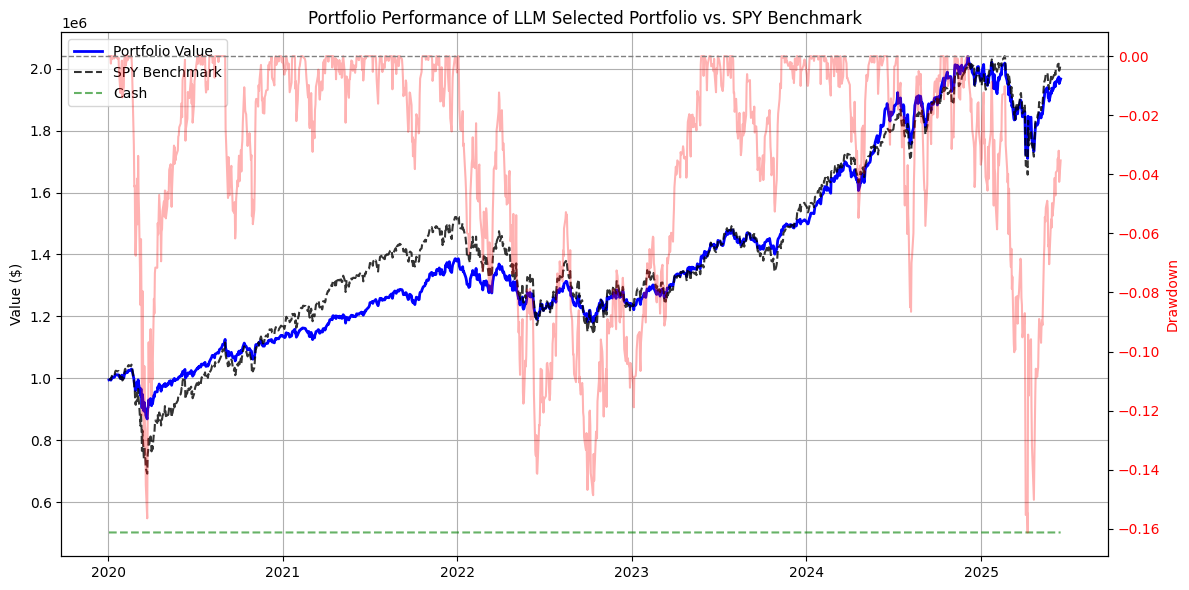

Backtester state has been reset.
Low Risk Portfolio Weights: { TLT: 0.3486, GLD: 0.2606, JNJ: 0.1393, WMT: 0.0717, JPM: 0.0555, LMT: 0.0463, XOM: 0.0284, PG: 0.0250, UPS: 0.0237, UNH: 0.0008, MSFT: 0.0001, }
Expected Log Return: 0.0430
Volatility: 0.0634
Sharpe: 0.6787
Max Drawdown: -0.0856


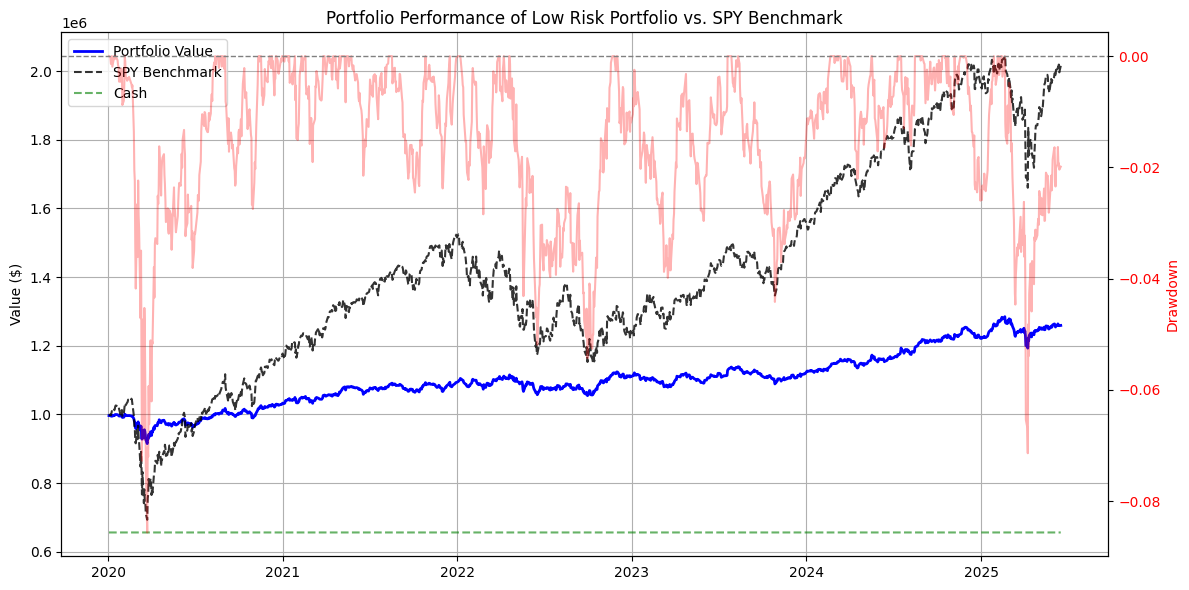

Backtester state has been reset.
High Sharpe Portfolio Weights: { GLD: 0.4798, NVDA: 0.2216, WMT: 0.1853, TSLA: 0.0707, XOM: 0.0425, }
Expected Return: 0.3452
Volatility: 0.3175
Sharpe: 1.0871
Max Drawdown: -0.3928


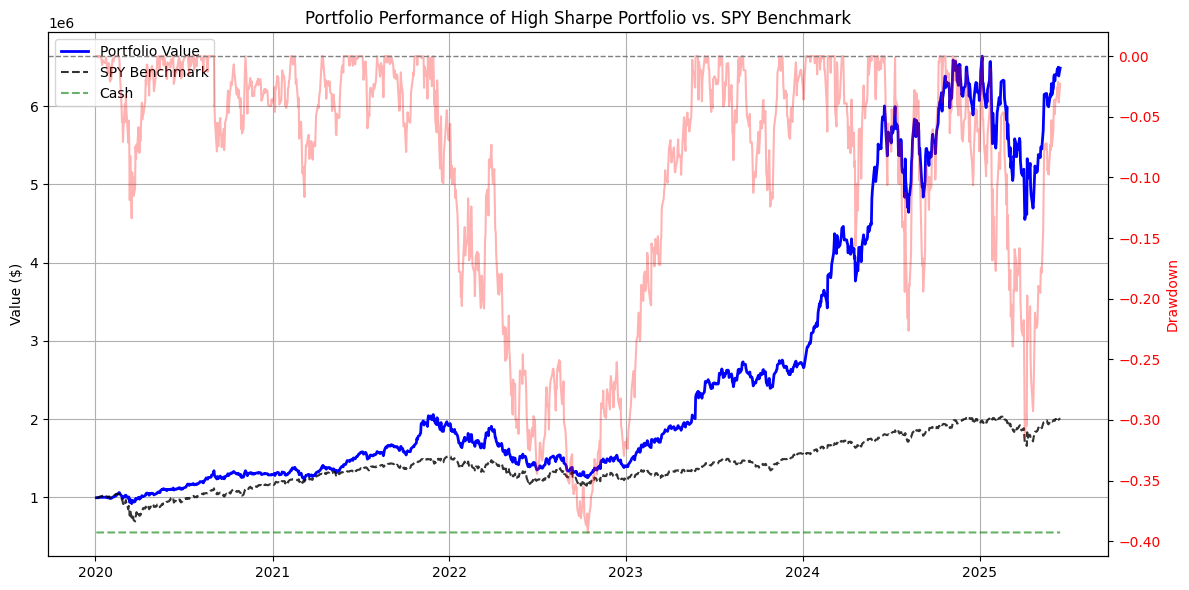

In [39]:
print("LLM Picked Weights: { ", end="")
for symbol, weight in weights.items():
    print(f"{symbol}: {weight:.4f}", end=", ")
print("}")
print(f"Expected Log Return: {eval_result['annualized_return']:.4f}")
print(f"Volatility: {eval_result['volatility']:.4f}")
print(f"Sharpe: {eval_result['sharpe_ratio']:.4f}")
print(f"Max Drawdown: {eval_result['max_drawdown']:.4f}")
backtester.plot("LLM Selected Portfolio")

backtester.reset()
agent = SimpleBuyAndHoldAgent(low_risk_weight_dict)
backtester.run(agent)
eval_result = backtester.evaluate()
print("Low Risk Portfolio Weights: { ", end="")
for symbol, weight in low_risk_weight_dict.items():
    if weight > 0.0001:
        print(f"{symbol}: {weight:.4f}", end=", ")
print("}")
print(f"Expected Log Return: {eval_result['annualized_return']:.4f}")
print(f"Volatility: {eval_result['volatility']:.4f}")
print(f"Sharpe: {eval_result['sharpe_ratio']:.4f}")
print(f"Max Drawdown: {eval_result['max_drawdown']:.4f}")
backtester.plot("Low Risk Portfolio")

backtester.reset()
agent = SimpleBuyAndHoldAgent(high_risk_weight_dict)
backtester.run(agent)
eval_result = backtester.evaluate()
print("High Sharpe Portfolio Weights: { ", end="")
for symbol, weight in high_risk_weight_dict.items():
    if weight > 0.0001:
        print(f"{symbol}: {weight:.4f}", end=", ")
print("}")
print(f"Expected Return: {eval_result['annualized_return']:.4f}")
print(f"Volatility: {eval_result['volatility']:.4f}")
print(f"Sharpe: {eval_result['sharpe_ratio']:.4f}")
print(f"Max Drawdown: {eval_result['max_drawdown']:.4f}")
backtester.plot("High Sharpe Portfolio")